In [30]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
loader = ToTensor()

In [3]:
im = Image.open('./360.jpg')

In [102]:
# Adapted from: https://github.com/bingsyslab/360projection/blob/master/equirectangular.py

def xrotation(th):
    c = np.cos(th)
    s = np.sin(th)
    return np.array([[1, 0, 0], [0, c, s], [0, -s, c]])

def yrotation(th):
    c = np.cos(th)
    s = np.sin(th)
    return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])

def render_image_np(theta0, phi0, fov_h, fov_v, width, img):
    """
    theta0 is pitch
    phi0 is yaw
    render view at (pitch, yaw) with fov_h by fov_v
    width is the number of horizontal pixels in the view
    
    Returns a (height, width, 2) matrix containing the
    pixels to sample from (in the source img)
    to project from sphere->perspective.
    """
    m = np.dot(yrotation(phi0), xrotation(theta0))
  
    (base_height, base_width, _) = img.shape

    height = int(width * np.tan(fov_v / 2) / np.tan(fov_h / 2))
    
    DI = np.ones((height * width, 3), np.int)
    trans = np.array([[2.*np.tan(fov_h / 2) / float(width), 0., -np.tan(fov_h / 2)],
                      [0., -2.*np.tan(fov_v / 2) / float(height), np.tan(fov_v / 2)]])
  
    xx, yy = np.meshgrid(np.arange(width), np.arange(height))
  
    DI[:, 0] = xx.reshape(height * width)
    DI[:, 1] = yy.reshape(height * width)

    v = np.ones((height * width, 3), np.float)

    v[:, :2] = np.dot(DI, trans.T)
    v = np.dot(v, m.T)
  
    diag = np.sqrt(v[:, 2] ** 2 + v[:, 0] ** 2)
    theta = np.pi / 2 - np.arctan2(v[:, 1], diag)
    phi = np.arctan2(v[:, 0], v[:, 2]) + np.pi

    ey = theta * base_height / np.pi
    ex = phi * base_width / (2 * np.pi)

    ex[ex >= base_width] = base_width - 1
    ey[ey >= base_height] = base_height - 1  
  
    # Need to scale grid coordinates between [-1, +1] for use in grid_sample
    ey_grid = ey.reshape(height, width) / (base_height / 2.) - 1
    ex_grid = ex.reshape(height, width) / (base_width / 2.) - 1
    return np.stack([ex_grid, ey_grid], axis=-1)

## Usage

In [103]:
im_var = Variable(loader(im)[None], requires_grad=True)

In [113]:
im_var = Variable(torch.ones(1, 3, 2048, 4096), requires_grad=True)

In [114]:
coords = render_image_np(0, np.pi / 3, np.pi / 2, np.pi / 2, 200, np.array(im))
coords_var = Variable(torch.from_numpy(coords.astype(np.float32))[None], requires_grad=False)

In [115]:
projection_var = F.grid_sample(im_var, coords_var)

In [116]:
dummy_loss = torch.sum(projection_var)

In [117]:
dummy_loss.backward()

In [127]:
im_grad = np.squeeze(im_var.grad.data.numpy()).transpose([1, 2, 0])

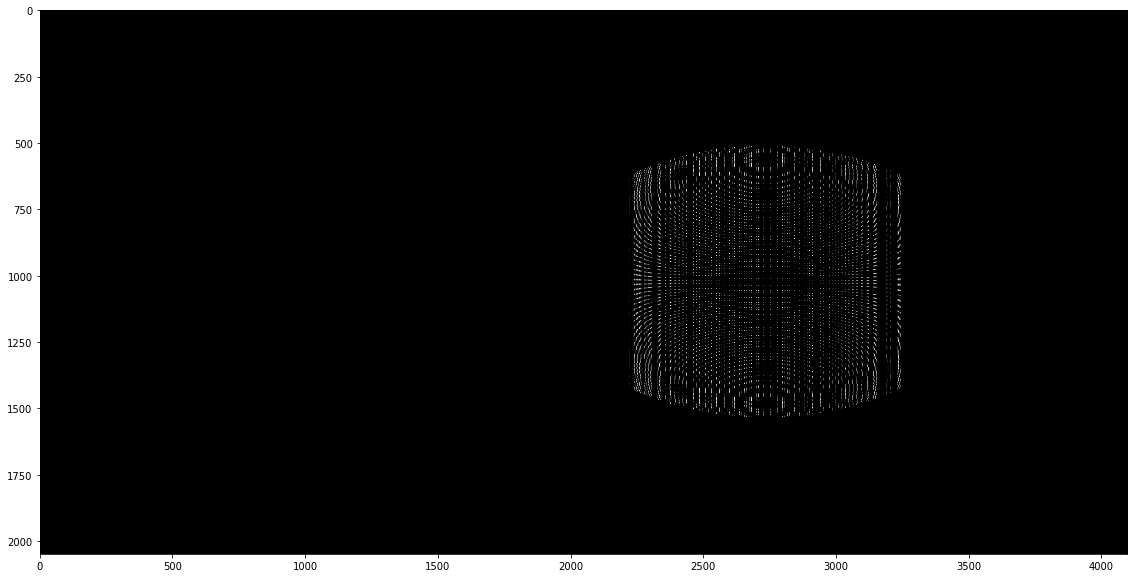

In [131]:
plt.figure(figsize = (20,10))
plt.imshow(im_grad)

In [110]:
projected_image = np.transpose(np.squeeze(projection_var.data.numpy()), [1, 2, 0])

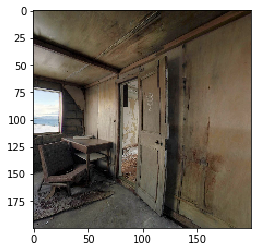

In [111]:
plt.imshow(projected_image)